# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Wzx7pSGcs2zv4AWIkxvCGQ79aByNOTLs?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

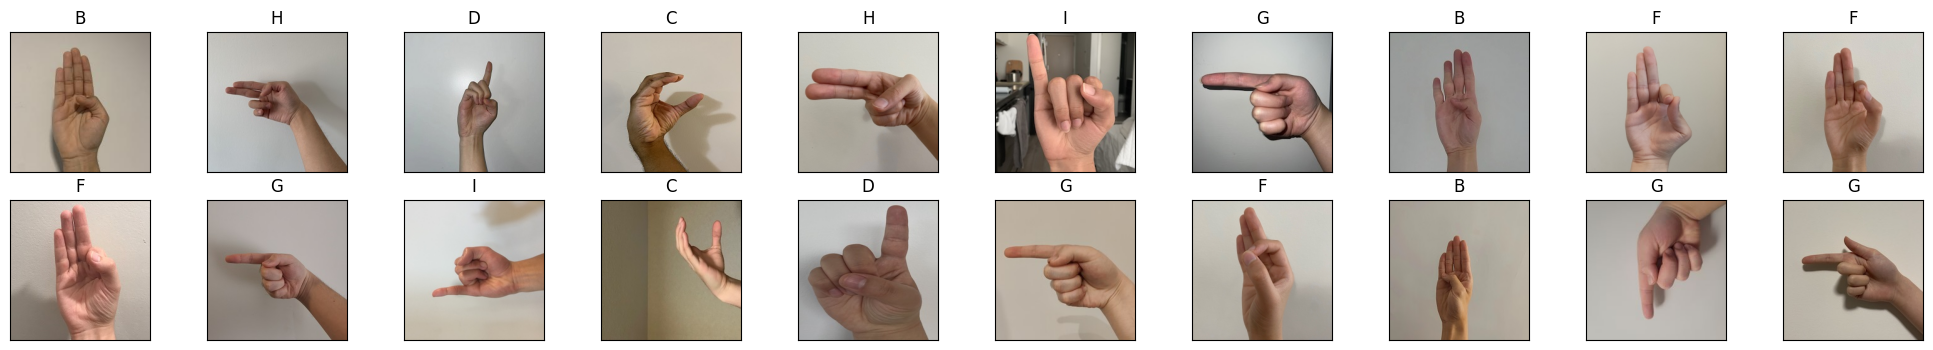

In [ ]:
gesture_path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/image'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

# Load data from google colab
dataset = torchvision.datasets.ImageFolder(gesture_path, transform=transform)

# Prepare Dataloader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=1, shuffle=True)
#list of indices that have labels corresponding to the target classes
indices = []
for i in range(len(dataset)):
  indices.append(i)

size = len(dataset)
# Split into train, validation and test
np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(indices)
split1 = int(len(indices) * 0.6)#split train by 60% of total
split2 = int(len(indices) * 0.2)#split validation by 20% of total
split3 = size-split1-split2

relevant_train_indices, relevant_val_indices, relevant_test_indices = indices[:split1], indices[split1:split1+split2], indices[split3:]

train_dataset, val_dataset, test_dataset = random_split(dataset, [split1, split2, split3])

#get train_loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#define classes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# from tut 3b
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                            batch_size,
                            learning_rate,
                            epoch)
    return path

In [ ]:
print("Number of training example in training set is", len(train_loader.sampler))
print("Number of training example in validation set is",len(val_loader.sampler))
print("Number of training example in test set is",len(test_loader.sampler))
print("Number of total data is",len(data_loader.sampler))

Number of training example in training set is 1315
Number of training example in validation set is 438
Number of training example in test set is 439
Number of total data is 2192


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN_model"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 53 * 53, 32)
        self.fc2 = nn.Linear(32, 9)

# o=i-k+1 for convolutional layer and o=(i-k)/s+1 for pool
# calculate the output size to be 53 if input is 224

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
# My choice is CNN architecture.
# I choose two convolutional layers and two fully-connected layers.
# For the 1st covolutional layer:
# input_channels = 3, output_channels = 5, kernel_size = 5
# Pooling layers size is 2*2: kernel_size=2, stride=2,
# type of function is "relu".
# For the 2nd covolutional layer:
# input_channels = 5, output_channels = 10, kernel_size = 5
# I have 32 hidden units.

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
#from tut 3b
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
#from tut 3b and lab2
def train(model, train_loader, val_loader, batch_size=27, learn_rate = 0.01, num_epochs=1):
  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss() #Use CE loss function
  optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9) #Use SGD optimizer
  losses, train_acc, val_acc, iters = [], [], [], []
  start_time = time.time() #set timer

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):

    for imgs, labels in iter(train_loader):
      #############################################
      #To Enable GPU Usage
      if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

    iters.append(n)
    losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
    val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    print(("Epoch {}: Train acc: {} |"+"Validation acc: {}").format(
                epoch + 1,
                train_acc[-1],
                val_acc[-1]))
    n+=1

  #calculate time
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# I use CE since there are multiple classes, BCE can not be used here.
# I use SGD optimizer, since it can access global data more easily.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
#from tut3
def get_accuracy_small(model, small_loader):
  data = small_loader

  correct = 0
  total = 0
  for imgs, labels in data:

  #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)

  #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

  return correct / total

In [13]:
#from lab2 and tut3
def train_small(model, data, batch_size=27, learning_rate=0.001, num_epochs=1):
  train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  iters, losses, train_acc = [], [], []

  small_loader = torch.utils.data.DataLoader(small_dataset, batch_size=27,
                                  shuffle=True)
  #small_loader = torch.tensor(small_loader)
  start_time = time.time()
  # training
  epoch = 0 # the number of iterations
  for epoch in range(num_epochs):
    for imgs, labels in iter(small_loader):

      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################


      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

  # save the current training information
    iters.append(epoch)
    losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy_small(model, small_loader)) # compute training accuracy
    print(("Epoch {}: Train acc: {}").format(
            epoch + 1,
            train_acc[-1]))
  model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
  torch.save(model.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))

In [ ]:
#tut 3b

use_cuda = True

drive.mount('/content/drive')
small_path = '/content/drive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/small_set'

classes = ["A", "B", "C", "D", "E", "F", "G", "H", "I"]

small_dataset = torchvision.datasets.ImageFolder(small_path,transform=transforms.ToTensor())

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train_small(model, small_dataset, num_epochs=100)

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
#Batch Size
#Learning rate
#Stride/Padding of Convolutional Layers

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.11634980988593156 |Validation acc: 0.1050228310502283
Epoch 2: Train acc: 0.2874524714828897 |Validation acc: 0.2945205479452055
Epoch 3: Train acc: 0.34448669201520915 |Validation acc: 0.3675799086757991
Epoch 4: Train acc: 0.46387832699619774 |Validation acc: 0.4315068493150685
Epoch 5: Train acc: 0.5642585551330799 |Validation acc: 0.5570776255707762
Epoch 6: Train acc: 0.6410646387832699 |Validation acc: 0.6027397260273972
Epoch 7: Train acc: 0.6874524714828897 |Validation acc: 0.6301369863013698
Epoch 8: Train acc: 0.7444866920152091 |Validation acc: 0.6529680365296804
Epoch 9: Train acc: 0.6897338403041825 |Validation acc: 0.6210045662100456
Epoch 10: Train acc: 0.7650190114068441 |Validation acc: 0.680365296803653
Epoch 11: Train acc: 0.7908745247148289 |Validation acc: 0.6963470319634704
Epoch 12: Train acc: 0.7543726235741445 |Validation acc: 0.6872146118721462
Epoch 13: Train acc: 0.7650190114068441 |Validation acc

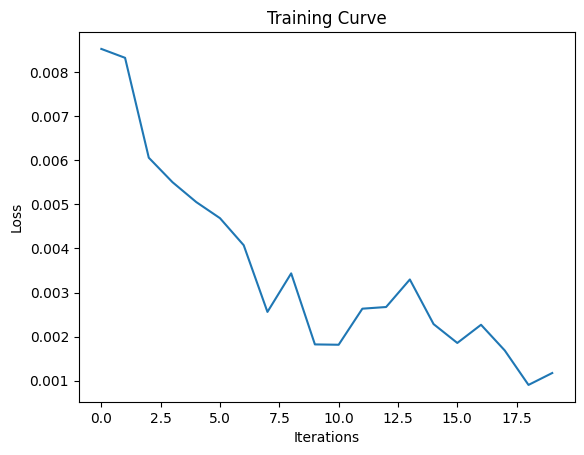

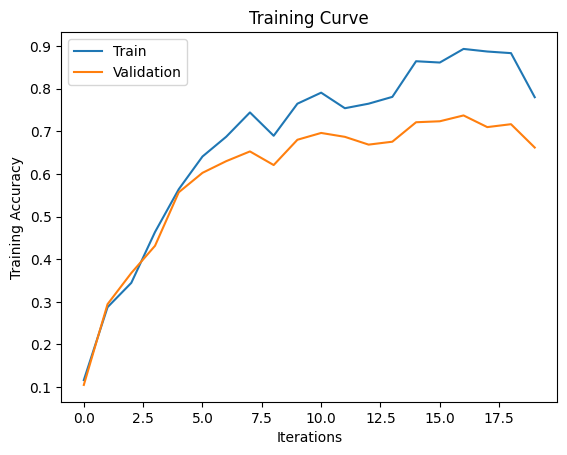

Final Training Accuracy: 0.7802281368821293
Final Validation Accuracy: 0.6621004566210046


In [ ]:
use_cuda = True

model1= CNN()

if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model1, train_loader, val_loader, batch_size=256, learn_rate=0.01,num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.1155893536121673 |Validation acc: 0.1415525114155251
Epoch 2: Train acc: 0.11482889733840304 |Validation acc: 0.1415525114155251
Epoch 3: Train acc: 0.26539923954372624 |Validation acc: 0.2579908675799087
Epoch 4: Train acc: 0.4266159695817491 |Validation acc: 0.4292237442922374
Epoch 5: Train acc: 0.6319391634980989 |Validation acc: 0.6164383561643836
Epoch 6: Train acc: 0.7072243346007605 |Validation acc: 0.6757990867579908
Epoch 7: Train acc: 0.6433460076045627 |Validation acc: 0.6027397260273972
Epoch 8: Train acc: 0.7604562737642585 |Validation acc: 0.684931506849315
Epoch 9: Train acc: 0.7437262357414449 |Validation acc: 0.6643835616438356
Epoch 10: Train acc: 0.7520912547528517 |Validation acc: 0.6689497716894978
Epoch 11: Train acc: 0.8068441064638783 |Validation acc: 0.6940639269406392
Epoch 12: Train acc: 0.7338403041825095 |Validation acc: 0.682648401826484
Epoch 13: Train acc: 0.776425855513308 |Validation acc: 0

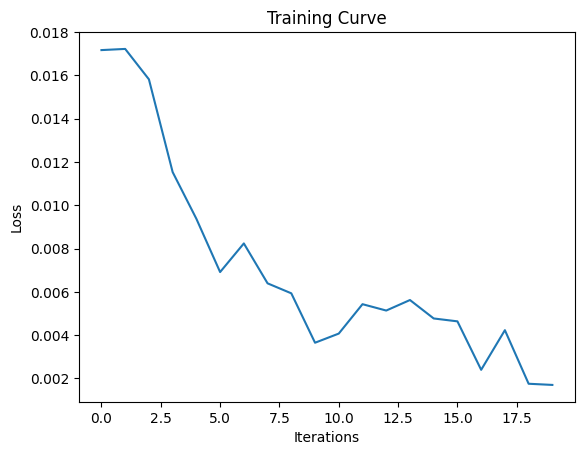

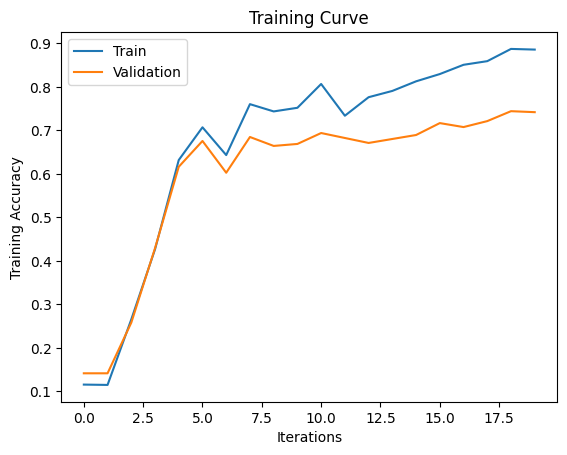

Final Training Accuracy: 0.8859315589353612
Final Validation Accuracy: 0.7420091324200914


In [ ]:
use_cuda = True

model2= CNN()

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model2, train_loader, val_loader, batch_size=128, learn_rate=0.007,num_epochs=20)

CUDA is available!  Training on GPU ...
Epoch 1: Train acc: 0.11178707224334601 |Validation acc: 0.08447488584474885
Epoch 2: Train acc: 0.1300380228136882 |Validation acc: 0.09360730593607305
Epoch 3: Train acc: 0.13307984790874525 |Validation acc: 0.1187214611872146
Epoch 4: Train acc: 0.11711026615969582 |Validation acc: 0.09817351598173515
Epoch 5: Train acc: 0.11634980988593156 |Validation acc: 0.091324200913242
Epoch 6: Train acc: 0.15361216730038021 |Validation acc: 0.1278538812785388
Epoch 7: Train acc: 0.19923954372623573 |Validation acc: 0.2009132420091324
Epoch 8: Train acc: 0.19923954372623573 |Validation acc: 0.20776255707762556
Epoch 9: Train acc: 0.24866920152091254 |Validation acc: 0.20319634703196346
Epoch 10: Train acc: 0.3133079847908745 |Validation acc: 0.2899543378995434
Epoch 11: Train acc: 0.32927756653992396 |Validation acc: 0.3264840182648402
Epoch 12: Train acc: 0.44106463878326996 |Validation acc: 0.4292237442922374
Epoch 13: Train acc: 0.4281368821292776 |Va

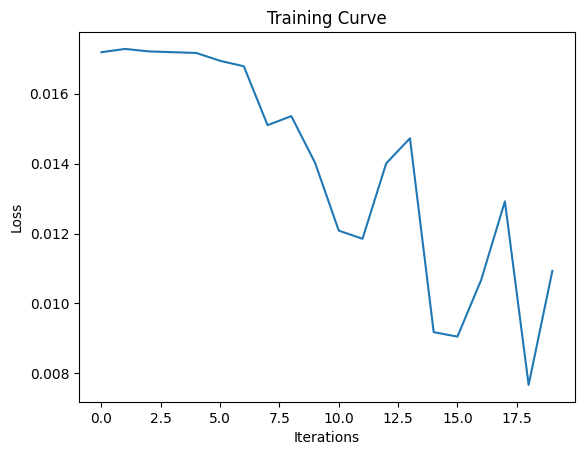

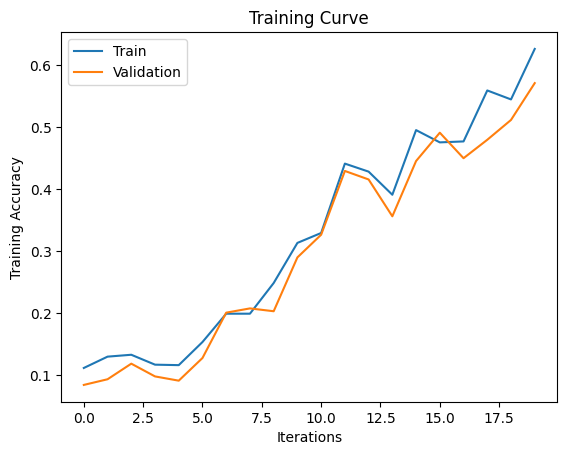

Final Training Accuracy: 0.6258555133079848
Final Validation Accuracy: 0.5707762557077626


In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.name = "CNN_2"
        self.conv1 = nn.Conv2d(3, 5, 3, stride=2, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 5, 7, stride=2, padding=2)
        self.fc1 = nn.Linear(5 * 13 * 13, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

use_cuda = True

model3= CNN_2()

if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model3, train_loader, val_loader, batch_size=128, learn_rate=0.007,num_epochs=20)

CUDA is available! Training on GPU ...
Epoch 1: Train acc: 0.11863117870722434 |Validation acc: 0.14383561643835616
Epoch 2: Train acc: 0.11482889733840304 |Validation acc: 0.1415525114155251
Epoch 3: Train acc: 0.16806083650190115 |Validation acc: 0.182648401826484
Epoch 4: Train acc: 0.3650190114068441 |Validation acc: 0.3607305936073059
Epoch 5: Train acc: 0.5642585551330799 |Validation acc: 0.5547945205479452
Epoch 6: Train acc: 0.6456273764258555 |Validation acc: 0.6210045662100456
Epoch 7: Train acc: 0.6539923954372624 |Validation acc: 0.6278538812785388
Epoch 8: Train acc: 0.7566539923954373 |Validation acc: 0.6689497716894978
Epoch 9: Train acc: 0.7315589353612167 |Validation acc: 0.6712328767123288
Epoch 10: Train acc: 0.7406844106463878 |Validation acc: 0.6506849315068494
Epoch 11: Train acc: 0.7931558935361217 |Validation acc: 0.7100456621004566
Epoch 12: Train acc: 0.7992395437262357 |Validation acc: 0.6986301369863014
Epoch 13: Train acc: 0.7581749049429658 |Validation acc

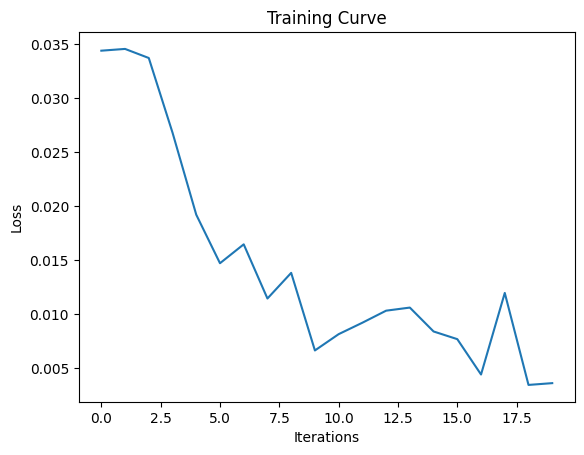

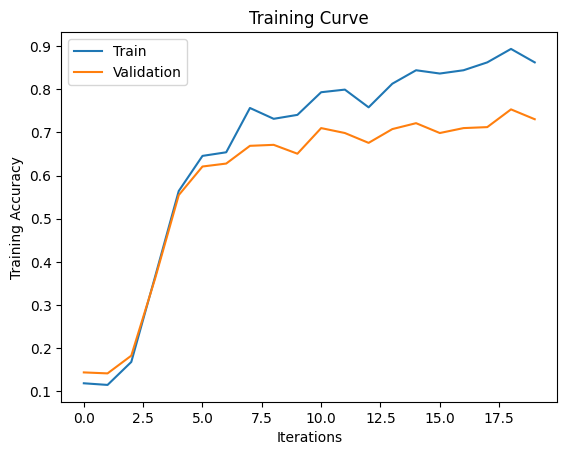

Final Training Accuracy: 0.8623574144486692
Final Validation Accuracy: 0.730593607305936


In [ ]:
use_cuda = True

model4 = CNN()

if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

train(model4, train_loader, val_loader, batch_size=64, learn_rate=0.005, num_epochs=20)

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
# the change of paddling/stride in CNN model does not work better,
# I would use CNN model rather than new CNN model.
# As tring three pairs of batch_size and learning rate
# When batch_size = 64, learning_rate = 0.005, num_epochs = 20
# Traning acc =0.86/Validation acc =0.73
# This is the highest value of all attempts.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
# Define the accuracy function
def test_accuracy(model, data_loader):
  correct = 0
  total = 0
  for imgs, labels in data_loader:
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

    output = model(imgs)

    # Select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]

    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]

  return correct / total

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)
test_acc = test_accuracy(model4, test_loader)

# Print or use the accuracy as needed
print(f"Accuracy: {test_acc * 100:.2f}%")

Accuracy: 73.12%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
import time
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [ ]:
# location on Google Drive
path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/Features'

# define classes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [ ]:
# transfer data into tensor
def feature_trans(loader,catgory):
  n = 0
  print("creating: ",catgory)
  for imgs, labels in iter(loader):
      features = alexnet.features(imgs) #find features of imgs
      features_tensor = torch.from_numpy(features.detach().numpy()) #transfer into np array
      foldername = path + '/' + catgory + '/' + str(classes[labels])
      valid_path = os.path.isdir(foldername)
      if not valid_path:
        os.mkdir(foldername)
      torch.save(features_tensor.squeeze(0), foldername + '/' + str(n) + '.tensor') #save in new addr
      n += 1

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [ ]:
feature_trans(train_loader,"train")
feature_trans(val_loader,"val")
feature_trans(test_loader,"test")

creating:  train
creating:  val
creating:  test


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
class CNN3(nn.Module):
  def __init__(self):
    super(CNN3, self).__init__()
    self.name = "CNN3"
    self.conv1 = nn.Conv2d(256, 256, 2, stride=1, padding=1)
    self.conv2 = nn.Conv2d(256, 256, 2, stride=2, padding=0)
    self.fc1 = nn.Linear(256 * 3 * 3, 32)
    self.fc2 = nn.Linear(32, 9)

#o=(i+2p-k)/s+1 for convolutional layer  3=(6-2)/2+1
# The input is 256*6*6, the output size is 256*3*3

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(-1, 256 * 3 * 3)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1) # Flatten to [batch_size]
    return x

In [ ]:
# I choose the CNN model with 2 convolutional layer, and 2 fully-connected layers.
# The convolutional layer will be able to learn more specific features from AlexNet
#and the fully-connected layers will be able to classify these extracted features.
# I dont use pooling layers since I am afraid that it will lost features.
# I used relu since I only need positive values.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
# location on Google Drive
train_path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/Features/train'
valid_path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/Features/val'
test_path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/Features/test'

# Load data from Google Drive
train2_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
valid2_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))
test2_dataset = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

train2_loader = DataLoader(train2_dataset, batch_size=128, shuffle=True)
val2_loader = DataLoader(valid2_dataset, batch_size=128, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=128, shuffle=False)

In [ ]:
use_cuda = True

model5 = CNN3()

if use_cuda and torch.cuda.is_available():
  model5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model5, train2_loader, val2_loader, batch_size=64, learn_rate=0.005, num_epochs=20)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
test_loader = torch.utils.data.DataLoader(test2_dataset, batch_size=64)
test_acc = test_accuracy(model5, test_loader)

# Print or use the accuracy as needed
print(f"Accuracy: {test_acc * 100:.2f}%")

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
small_path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/small_set'
im_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
dataset_small = torchvision.datasets.ImageFolder(small_path, transform=im_transform)

In [ ]:
small_class = ['A','B','C','D','E','F','G','H','I']
path = '/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/small_alexset'
def feature_trans_small(loader,catgory):
  n = 0
  print("creating: ",catgory)
  for imgs, labels in iter(loader):
      features = alexnet.features(imgs) #find features of imgs
      features_tensor = torch.from_numpy(features.detach().numpy()) #transfer into np array
      foldername = path + '/' + catgory + '/' + str(small_class[labels])
      valid_path = os.path.isdir(foldername)
      if not valid_path:
        os.mkdir(foldername)
      torch.save(features_tensor.squeeze(0), foldername + '/' + str(n) + '.tensor') #save in new addr
      n += 1

In [ ]:
feature_trans_small(test_loader,"test")

In [ ]:
small_test_path='/content/gdrive/MyDrive/APS360_Lab3/Lab3_Gestures_Summer/small_alexset/test'
small_test_alex = torchvision.datasets.DatasetFolder(small_test_path, loader = torch.load, extensions=('.tensor'))
test_loader = torch.utils.data.DataLoader(small_test_alex, batch_size=64)
test_acc = test_accuracy(model5, test_loader)
print(f"Accuracy: {test_acc * 100:.2f}%")

Accuracy: 29.63%
